# Hearing Application

## Introduction

In this notebook, we will explore some interesting hearing experiences using the `AudioSigPy` package. The examples here will simulate the following auditory experiences:
- Lyric-Separated Listening
- Hearing Loss Experience
- Cochlear implant (CI) Experience

This demonstration is intended to showcase the capabilities of `AudioSigPy` in simulating complex auditory experiences, and the following sections will guide you through the process. Note that liberties were taken to simplify these processes, so they don't closely reflect real experiences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import AudioSigPy as asp

asp.manage_directory("audio/examples/hearing")

AudioSigPy package initialized
[WARNING] Manage Directory: The directory audio/examples/hearing already exists and will not be deleted.


## Stereo Hearing Experiences

Stereo hearing is an essential aspect of how we perceive sound in our environment, providing depth and directionality. In this section, we'll explore how different audio sources—such as [two languages](https://youtu.be/2GoEuuMEkng?si=pRW2nbcfXqKpIVVV) or the blend of vocals and music—can be combined to create a stereo auditory experience. This is may be a useful perspective for applications in language learning, music production, or audio engineering.

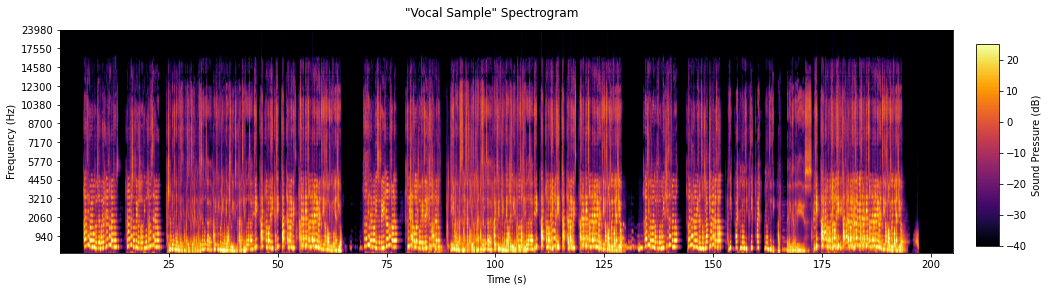

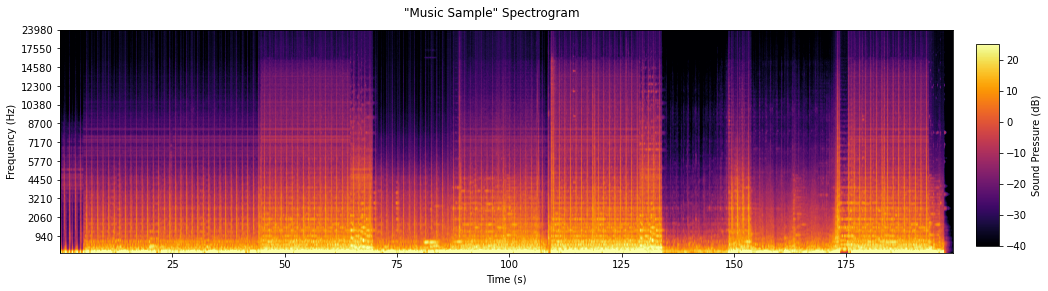

In [2]:
# Antihero Vocal track
vocal = asp.Waveform("Vocal Sample")
vocal.read("audio/samples/songs/anti-hero-vocal.wav")
vocal.plot_spectrogram()

# Antihero Music track
music = asp.Waveform("Music Sample")
music.read("audio/samples/songs/anti-hero-instrumental.wav")
music.plot_spectrogram()

In [3]:
# Combine tracks
fs = vocal.get_sample_rate() # Ensure sample rates match
N = np.min([vocal.get_sample_count(), music.get_sample_count()])
data = np.hstack([
    vocal.get_signal_data()[:N],
    music.get_signal_data()[:N]
])

# Vocal track on Left Channel
wf_left = asp.Waveform("Left Vocals")
wf_left.set_signal_data(data=data, sample_rate=fs)
wf_left.write("audio/examples/hearing/left-vocals.wav")

# Vocal track on Right Channel
wf_right = asp.Waveform("Right Vocals")
wf_right.set_signal_data(data=data[:, [1, 0]], sample_rate=fs)
wf_right.write("audio/examples/hearing/right-vocals.wav")

## Hearing Loss Experience

Audiograms are visual representations of an individual's hearing thresholds across different frequencies. By simulating these thresholds and applying them as filters to audio signals, we can mimic the auditory experience of someone with hearing loss. This simulation is invaluable for understanding the challenges faced by individuals with hearing impairments and for designing accessible audio content or devices.

In [4]:
# Creates a pseudo audiogram threshold
def audiogram(x, hearing, level):
    x = np.sort(x)
    y = 1 / (1 + np.exp(-0.5e-3 * (x - np.max(x)))) * 200 + 15
    
    def askewed(x, peak_x, peak_height, peak_width):
        little_notch = peak_height * np.exp(-((x - peak_x) ** 2) / (2 * (peak_width / 2) ** 2))
        notch = peak_height * np.exp(-((x - peak_x) ** 2) / (2 * peak_width ** 2))
        notch[:len(x[x <= peak_x])] = little_notch[:len(x[x <= peak_x])]
        return notch
        
    if hearing == "noise-exposed":
        magnitudes = {"low": 15, "medium": 50, "high": 85}
        y += askewed(x, 4000, magnitudes[level], 1600)
    
    if hearing == "sensor-loss":
        magnitudes = {"low": 30, "medium": 65, "high": 100}
        ymin, ymax = np.min(y), np.max(y)
        y = (y - ymin) / (ymax - ymin) * (ymax - magnitudes[level]) + magnitudes[level]
        y += askewed(x, 8000, 5, 8000)
    
    return x, y

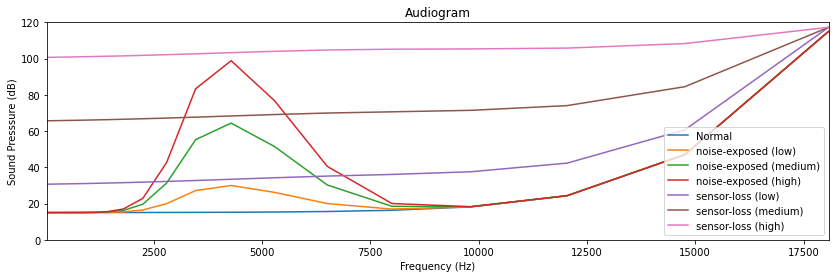

In [5]:
# Initialize a processor object to get frequencies
deaf_proc = asp.Processor(band_count=22, scale="erb")
freqs = deaf_proc.calc_bands(band_count=22, scale="erb", ftype="centre").flatten()

# Generate the auidogram thresholds for different types/levels hearing
x, y = audiogram(freqs, None, None)
plt.figure(figsize=(14, 4))
plt.plot(x, y, label="Normal")

for h in ["noise-exposed", "sensor-loss"]:
    for l in ["low", "medium", "high"]:
        x, y = audiogram(freqs, h, l)
        plt.plot(x, y, label=f"{h} ({l})")
        
plt.ylim(0, 120)
plt.xlim(np.min(freqs), np.max(freqs))
plt.ylabel("Sound Presssure (dB)")
plt.xlabel("Frequency (Hz)")
plt.title("Audiogram")
plt.legend(loc="lower right")
plt.show()

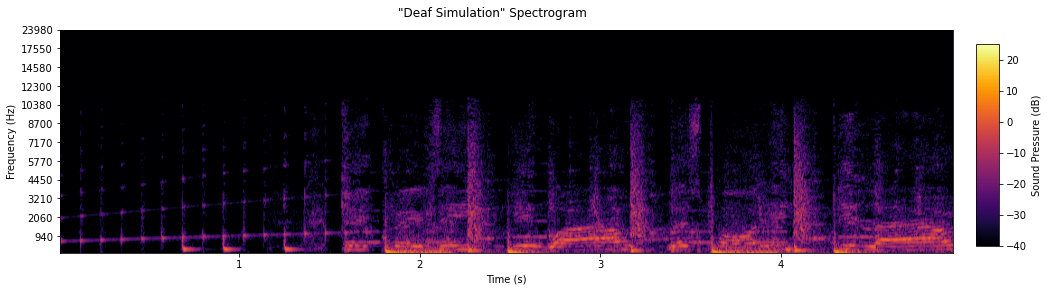

In [12]:
# Load and extract data for processing
audio = asp.Waveform("Audio Sample")
audio.read("audio/samples/songs/get-crazy-sample.wav")
data = audio.get_signal_data()
fs = audio.get_sample_rate()

# Scale pressure to 80 dB
data, _ = asp.spl_transform(signal=data, target_spl=80)

# Create audigram threshold for deaf signal
htype, hlevel = "sensor-loss", "low"
_, thresholds = audiogram(freqs, htype, hlevel)
deaf_signal = []

# Iterate over each channel of signal
for channel in range(data.shape[1]):
    # Generate filterbank on input audio signal
    streams, _ = deaf_proc.filterbank(signal=data[:, channel], sample_rate=fs)
    for i in range(streams.shape[1]):
        spl = asp.calc_spl(signal=streams[:, i])[0][0]
        # Transform sound pressure level
        streams[:, i] = asp.spl_transform(
            signal=streams[:, i], target_spl=spl - thresholds[-(i+1)]
        )[0].flatten()
    deaf_signal.append(streams)

# Combine data into an audio signal
deaf_signal = np.stack(deaf_signal, axis=1).sum(axis=2)
wf_deaf = asp.Waveform("Deaf Simulation")
wf_deaf.set_signal_data(data=deaf_signal, sample_rate=fs)
wf_deaf.plot_spectrogram(channel=0)
wf_deaf.write(f"audio/examples/hearing/deaf-{htype}-{hlevel}.wav")

## Cochlear Implant (CI) Processor Demo

Cochlear Implants are medical devices that provide a sense of sound to individuals with severe hearing loss. They work by bypassing the damaged parts of the ear and directly stimulating the auditory nerve. This is achieved with electrical stimulation rather than natural vibrations, so the experience is quite different from normal hearing. This section will demonstrate the use of a CI processor algorithm in `AudioSigPy`, which mimics the processing and electrical stimulation performed by actual cochlear implant processors.

In [7]:
# Load audio data
audio = asp.Waveform("Audio Sample")
audio.read("audio/samples/speech/breaking-bad-awake.wav")

data = audio.get_signal_data()
fs = audio.get_sample_rate()

# Create a cochlear implant processor
ci = asp.Cochlear()

# Pre-process audio for cochlear implant signal
prep_signal = ci.process(signal=data, sample_rate=fs)

# Generate a "true" signal for cochlear implant
true_signal = ci.signal(signal=prep_signal, sample_rate=fs)

# Generate a "simulated" signal for normal hearing
sim_signal = ci.simulate(signal=prep_signal, sample_rate=fs)

# Generate a visualization of cochlear implant signal
ci.visualize(
    streams=prep_signal[:, 0, :],
    sample_rate=fs,
    frame_rate=60,
    path="audio/examples/hearing/civis"
)

[UPDATE] Manage Directory: Created directory: audio/examples/hearing/civis
[UPDATE] Manage Directory: Deleted existing directory: audio/examples/hearing/civis
[UPDATE] Manage Directory: Created directory: audio/examples/hearing/civis


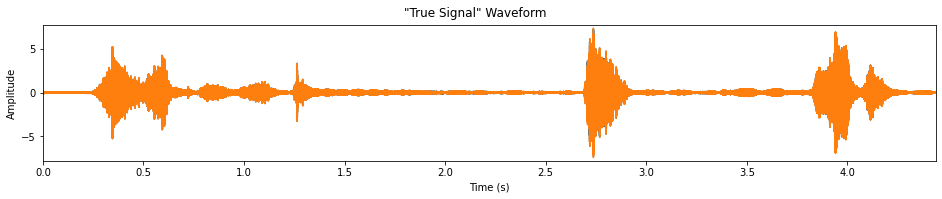

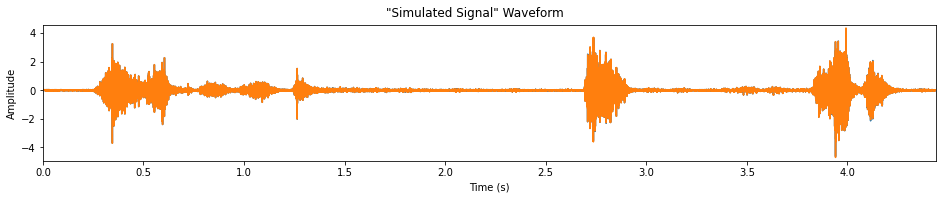

In [8]:
# Plot some data from each type of signal to compare them
wf_true = asp.Waveform("True Signal")
wf_true.set_signal_data(data=true_signal.sum(axis=2), sample_rate=fs)
wf_true.plot_waveform(overlay=True)

wf_sim = asp.Waveform("Simulated Signal")
wf_sim.set_signal_data(data=sim_signal, sample_rate=fs)
wf_sim.plot_waveform(overlay=True)

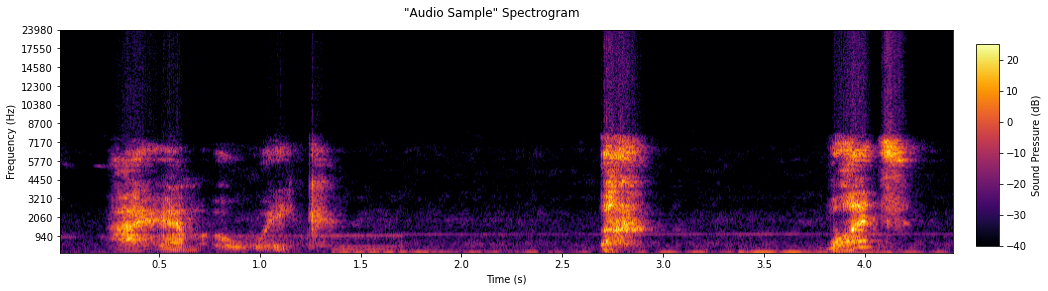

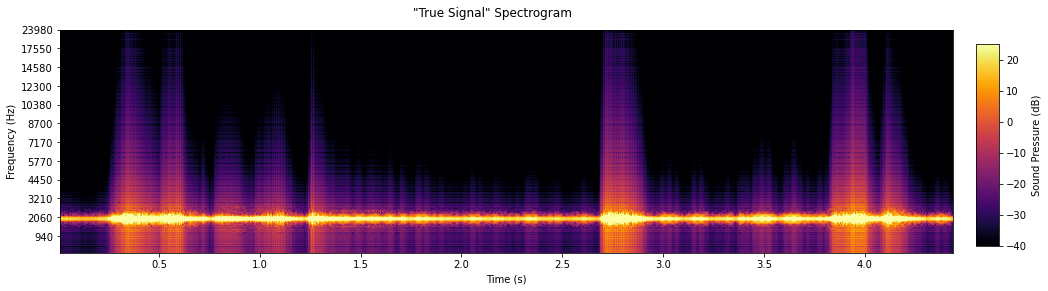

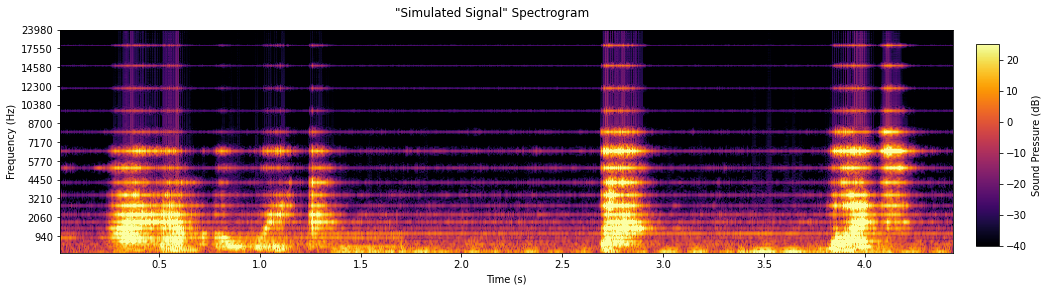

In [9]:
# Compare spectrograms of original and processed audio
audio.plot_spectrogram(channel=0)
wf_true.plot_spectrogram(channel=0)
wf_sim.plot_spectrogram(channel=0)

wf_true.write("audio/examples/hearing/ci-true.wav")
wf_sim.write("audio/examples/hearing/ci-sim.wav")